# Similarités entre séries

_recherche d'une mesure de similarité pertinente, associée à une feature representation pertinente_

### Principe

Dans ce qui suis nous utiliserons le terme "Document" pour dire "Série". Vu que l'on considère une série comme la concaténation de tous les sous titres de tous ses épisodes, et donc comme un long document.

Pour le calcul de similarité entre les documents, nous allons suivre la même méthode qu'avant :

représenter un document par un vecteur
utiliser des mesures de distance pour calculer la similarité entre deux vecteurs ( deux documents )
Ceci servira comme base pour faire un clustering de "genre" ou de "style" des documents. Nous allons pour un début tester juste une combinaison de possibilités:

démarrer à partir des vecteurs tf-idf des documents
vecteurs word embedding généré par Word2vec
distance de mesure : cosinus


#### Word embedding ?

Pour le définir rapidement, on peut dire que pour chaque mot du corpus on va avoir un vecteur de réels de taille fixe qui représentera d'une manière ou d'une autre le mot.

Et comme par magie des opérations vectoriels entre des mots ( vecteurs de réels ) nous donnes des mesures de similarités plutot correctes ! au lieu d'utiliser simplement tf-idf qui sont des vecteurs sparse.

Pour générer ces vecteurs nous allons utiliser Word2Vec entrainé sur le corpus entier, c'est à dire un gros fichier text qui contient l'ensemble des mots de tout le corpus.

#### Document embedding ?

D'accord on a une représentation vectorielle de chaque mot qui marche comme par magie, mais nous souhaterions avoir une représentation similaire pour chaque document ( afin de mesurer cette similarité par magie aussi ).

Pour cela nous allons utiliser un simple principe:

Soit V le vecteur représentant un Document lambda ( que ça soit tf-idf par exemple ) de taille N (N = nombre de mots du vocabulaire )
Soit la taille fixe du vecteur word embedding = p
Soit la matrice M = N x p , càd N lignes ( N = nombre de mots du vocabulaire ) et p colonnes, ou chaque ligne i est le vecteur word embedding obtenu à partir de word2vec correspondant au ieme mot du vocabulaire
Le vecteur D représentant le document embedding sera donc simplement : D = V.M ( biensure on va s'arranger pour que la multiplication se passe bien en alignant les bonnes dimensions )
pour faire facile : le document sera la somme des word embeddings des mots qui le composent ( pondéré par tf-idf dans notre cas )

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

from utils.load_data import getMostImportantSeries

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "dataset"

Reprenons notre liste de séries célèbres, étoffée cette fois-ci: la liste contient **44 séries de plusieurs genres différents**, triés de manière à former des "blocs" de séries du même genre.

In [12]:
genres = {
    "policier": ["2733_NCIS__Los_Angeles", "2956_Criminal_Minds", "1041_CSI__Crime_Scene_Investigation","1910_NCIS",
          "1830_CSI__Miami", "207_Bones", "2212_The_Mentalist", "2767_The_Blacklist", "413_Dexter", "1845_Sherlock_(2010)"],
    "science-fiction": ["884_The_X-Files", "3259_Stargate_SG-1", "381_Star_Trek__The_Next_Generation",
                       "2120_Doctor_Who_(1963)", "2091_Star_Trek__Deep_Space_Nine", "384_Twilight_Zone",
                       "186_Doctor_Who"],
    "humour": ["25_Friends", "1704_Rick_and_Morty", "2469_The_Simpsons",
              "2556_The_Big_Bang_Theory", "292_Modern_Family", "1718_South_Park", "95_How_I_Met_Your_Mother",
              "3012_Grey_s_Anatomy"],
    "action": ["2261_Buffy_The_Vampire_Slayer", "175_The_Walking_Dead", "1262_Lost", "1039_Narcos",
              "818_Gomorra_(2014)", "2123_Sense8", "3280_Peaky_Blinders", "121_Suits", "76_Breaking_Bad",
              "217_Game_of_Thrones", "2567_House"],
    "femme": ["1701_Outlander", "2936_Desperate_Housewives", "2053_Charmed", "345_Dallas", "1641_Pretty_Little_Liars",
             "3314_Shameless", "1906_The_Vampire_Diaries", "196_Smallville"]
}


series = []
for g in genres:
    series += genres[g]
    
print(len(series))

44


In [14]:
corpus = []

for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + file.read()
    corpus.append(text)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)

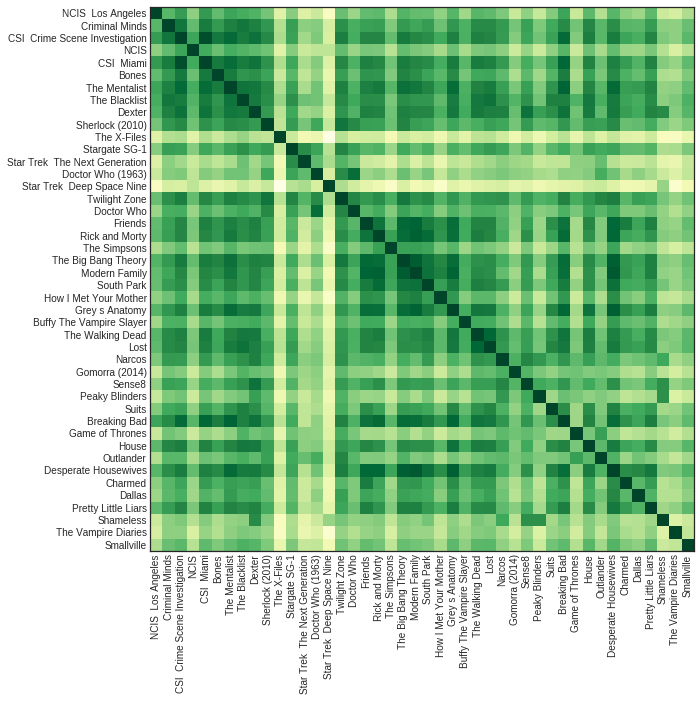

In [17]:
sim = np.zeros((len(series), len(series)))

for i in range(len(corpus)):
    for j in range(len(corpus)):
        dot = np.asscalar(vec[i].dot(vec[j].T).todense())
        norm1 = np.asscalar(vec[i].dot(vec[i].T).todense())
        norm2 = np.asscalar(vec[j].dot(vec[j].T).todense())
        sim[i][j] += dot/(norm1 * norm2) #sim cosinus

plt.figure(figsize=(10,10))
plt.imshow(sim, cmap='YlGn', interpolation='nearest')
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.yticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series])
plt.show()

#### Résultat:

On remarque la présence d'un carré assez sombre en haut à gauche: le modèle a reconnu une certaine similarité entre les séries de type "policier" comme esprits criminels, ou NCIS. Un autre "carré" est aussi présent dans l'image, qui correspond à une certaine similarité entre les séries dites "comiques" comme les simpsons, modern family, south park...

Cependant ce modèle est très mauvais: en particulier, aucune similarité n'est détectée entre les séries de science-fiction!

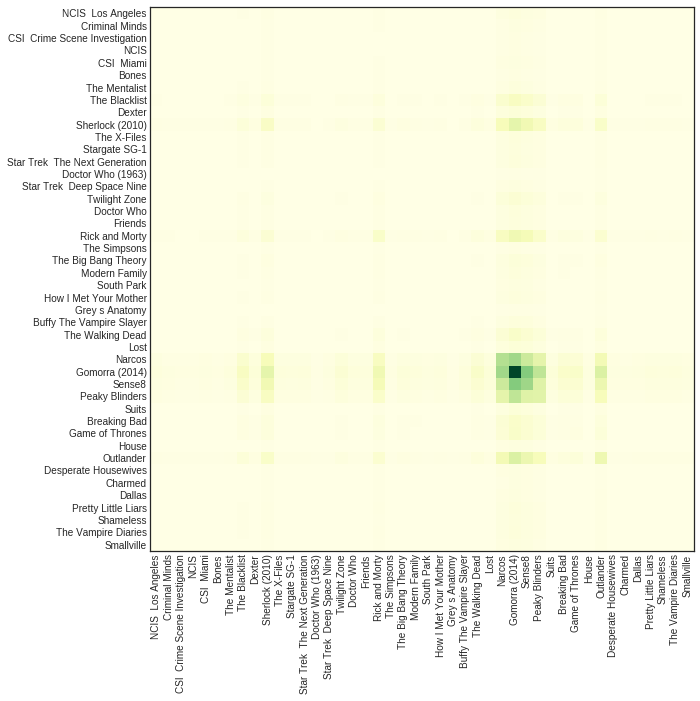

In [18]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)

vec = counter_vect.transform(corpus)

sim = np.zeros((len(series), len(series)))

for i in range(len(corpus)):
    for j in range(len(corpus)):
        dot = np.asscalar(vec[i].dot(vec[j].T).todense())
        norm1 = np.asscalar(vec[i].dot(vec[i].T).todense())
        norm2 = np.asscalar(vec[j].dot(vec[j].T).todense())  
        sim[i][j] += dot/(norm1 * norm2) #sim cosinus

plt.figure(figsize=(10,10))
plt.imshow(sim, cmap='YlGn', interpolation='nearest')
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.yticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series])
plt.show()

#### Résultat:

Cependant ce modèle est très mauvais: aucune similarité n'est détectée entre la majorité des séries, mise à part un seul carré sombre, qui correspond à une similarité entre quelques séries "d'action". Ce modèle doit souffrir du trop grand nombre de 0 que ses vecteurs comporte. 
- Essayons alors sans lissage cosinus:

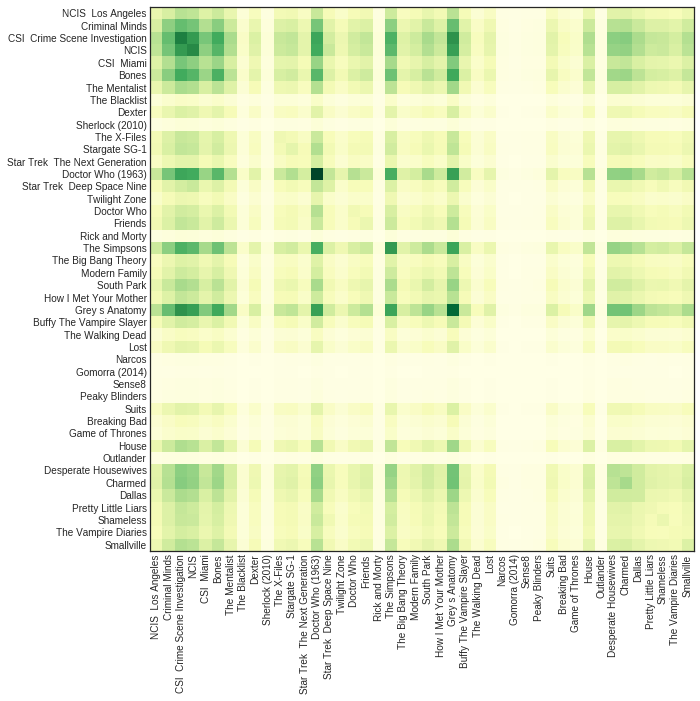

In [19]:
sim = np.zeros((len(series), len(series)))

for i in range(len(corpus)):
    for j in range(len(corpus)):
        dot = np.asscalar(vec[i].dot(vec[j].T).todense())
        sim[i][j] = dot
plt.figure(figsize=(10,10))
plt.imshow(sim, cmap='YlGn', interpolation='nearest')
plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
plt.yticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series])
plt.show()